# Task 3: Classification

In [ ]:
# imports
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from my_model_selection import grid_search_kfold_cv, evaluate_model

## 3.1 Classification with all features available

Our first approach is to use all the features available in the original dataset, and those we created in the previous task from those features.

In particular we can use `n_injured`, `n_unharmed` and `n_arrested` to predict `n_killed`. We can also use `n_participants`, `n_participants_adult`, `n_participants_child`, `n_participants_teen`, `n_participants_females` to predict `n_killed`.

### 3.1.1 Preparing data for classification

In [ ]:
# imports
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split

c:\Users\HUAWEI\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
df_incidents_prepared = pd.read_csv('../dataset_preparation/incidents_prepared.csv', index_col=0)
df_orig = pd.read_csv('../dataset_preparation/original_features.csv', index_col=0)

In [ ]:
df_incidents_prepared=df_incidents_prepared.join(df_orig)
df_incidents_prepared.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161550 entries, 0 to 164506
Data columns (total 41 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   date                       161550 non-null  object 
 1   state                      161550 non-null  object 
 2   city_or_county             161550 non-null  object 
 3   address                    149848 non-null  object 
 4   latitude                   161550 non-null  float64
 5   longitude                  161550 non-null  float64
 6   congressional_district     161550 non-null  float64
 7   avg_age_participants       161550 non-null  float64
 8   n_killed                   161550 non-null  int64  
 9   incident_characteristics1  161550 non-null  object 
 10  year                       161550 non-null  float64
 11  age_group                  161550 non-null  object 
 12  povertyPercentage          161550 non-null  float64
 13  population                 16

Now, `incidents_prepared` is the whole dataset with both original features and features created by us.
We decided to use only the original features for what concerns the gender and age groups of the participants: we kept `n_participants`, `n_participants_adult`, `n_participants_child`, `n_participants_teen`, `n_participants_females`. We dropped `n_participants_male` because it is highly correlated with `n_participants`.

In [ ]:
df_incidents_prepared['isKilled'] = df_incidents_prepared['n_killed'] > 0

In [ ]:
cols2drop=[
            #categorical features difficult to encode
           'address', 'city_or_county','congressional_district','date','state', 'year_month',
           'avg_age_participants', # we already have age_group
           'n_killed',  #label
           'incident_characteristics1', # too similar to the label isKilled
           'severity', 'severity_cat', # created from n_killed

           # we decided to use original features n_females, n_injured etc. all those features are highly correlated. We decided to keep the original features because they are more interpretable
           'killed_by_district','injured_by_district', 'dfm_district_killed','dfm_district_injured', 'dfm_district_participants', 'dfm_district_child', 'dfm_district_teen', 'dfm_district_females', 'arrested_ratio', 'unharmed_ratio', 'severity_minor',

           # correlated with n_participants
            'n_participants_adult'
            ]
df_incidents_prepared=df_incidents_prepared.drop(cols2drop, axis=1)

In [ ]:
df_incidents_prepared.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161550 entries, 0 to 164506
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   latitude                161550 non-null  float64
 1   longitude               161550 non-null  float64
 2   year                    161550 non-null  float64
 3   age_group               161550 non-null  object 
 4   povertyPercentage       161550 non-null  float64
 5   population              161550 non-null  int64  
 6   party                   161550 non-null  object 
 7   candidatevotes          161550 non-null  float64
 8   right_or_left           161550 non-null  float64
 9   voters_over_population  161550 non-null  float64
 10  n_arrested              161550 non-null  float64
 11  n_participants          161550 non-null  float64
 12  n_participants_teen     161550 non-null  float64
 13  n_participants_child    161550 non-null  float64
 14  n_females           

In [ ]:
X=df_incidents_prepared.drop('isKilled', axis=1)
y=df_incidents_prepared['isKilled']

In [ ]:
X.head()

,latitude,longitude,year,age_group,povertyPercentage,population,party,candidatevotes,right_or_left,voters_over_population,n_arrested,n_participants,n_participants_teen,n_participants_child,n_females,n_males,n_injured,n_unharmed
0,39.8322,-86.2492,2015.0,[18-24],12.3,6608422,DEMOCRAT,61443.0,0.452677,0.203046,0.0,1.0,0.0,0.0,0.0,1.0,1,0.0
1,39.7745,-86.1166,2015.0,[25-34],12.3,6608422,DEMOCRAT,61443.0,0.452677,0.203046,1.0,2.0,0.0,0.0,0.0,2.0,0,0.0
2,39.7759,-86.2940,2015.0,[35-44],12.3,6608422,DEMOCRAT,61443.0,0.452677,0.203046,1.0,2.0,0.0,0.0,0.0,2.0,0,0.0
3,39.8040,-86.0095,2015.0,[18-24],12.3,6608422,DEMOCRAT,61443.0,0.452677,0.203046,0.0,1.0,0.0,0.0,0.0,1.0,0,0.0
4,39.7882,-86.2091,2015.0,[45-54],12.3,6608422,DEMOCRAT,61443.0,0.452677,0.203046,0.0,1.0,0.0,0.0,0.0,1.0,1,0.0


One Hot Encoding of categorical features

In [ ]:
import pandas as pd
X=pd.get_dummies(X)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161550 entries, 0 to 164506
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   latitude                161550 non-null  float64
 1   longitude               161550 non-null  float64
 2   year                    161550 non-null  float64
 3   povertyPercentage       161550 non-null  float64
 4   population              161550 non-null  int64  
 5   candidatevotes          161550 non-null  float64
 6   right_or_left           161550 non-null  float64
 7   voters_over_population  161550 non-null  float64
 8   n_arrested              161550 non-null  float64
 9   n_participants          161550 non-null  float64
 10  n_participants_teen     161550 non-null  float64
 11  n_participants_child    161550 non-null  float64
 12  n_females               161550 non-null  float64
 13  n_males                 161550 non-null  float64
 14  n_injured           

### 3.1.2 Splitting data into train and test set

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

### 3.1.3 Logistic Regression

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [ ]:
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [ ]:
# fitting the model
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

LogisticRegression()

In [ ]:
# predictions
y_pred = logreg.predict(X_test_scaled)
y_pred_train = logreg.predict(X_train_scaled)

In [ ]:
# metrics
results_logreg = evaluate_model(logreg, X_train_scaled, y_train, X_test_scaled, y_test)

Accuracy on training set:  0.9764159702878366
confusion_matrix on training set: 
 [[90595  2310]
 [  738 35597]]
Accuracy on validation set:  0.9776539770968741
Confusion matrix: 
 [[22685   541]
 [  181  8903]]
Classification report: 
               precision    recall  f1-score   support

       False       0.99      0.98      0.98     23226
        True       0.94      0.98      0.96      9084

    accuracy                           0.98     32310
   macro avg       0.97      0.98      0.97     32310
weighted avg       0.98      0.98      0.98     32310



<Axes: >

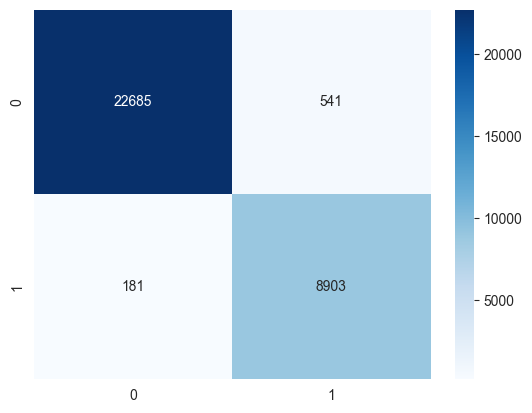

In [ ]:
# plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')

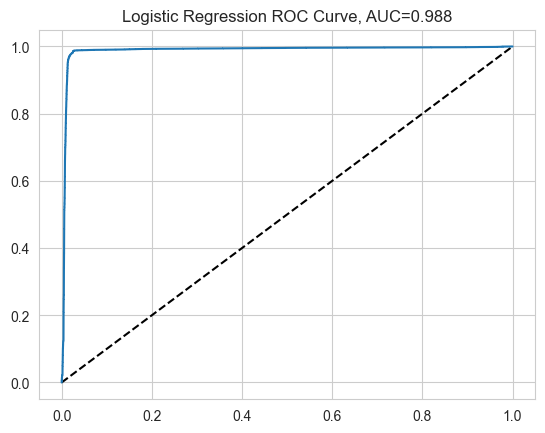

In [ ]:
# roc curve
from sklearn.metrics import roc_curve, roc_auc_score
y_pred_proba = logreg.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.title(f'Logistic Regression ROC Curve, AUC={ roc_auc_score(y_test, y_pred_proba):.3f}')
plt.show()

### Decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# grid search
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth': [4, 8, 16],
              'min_samples_split': [2,4, 8, 16],
              'criterion': ['gini', 'entropy']
}
best_param_dt, best_tree, results_dt = grid_search_kfold_cv(model_class=DecisionTreeClassifier, param_grid=param_grid, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,  cv=3, metric='f1', eval=True)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=2;, score=0.768 total time=   0.4s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=2;, score=0.761 total time=   0.5s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=2;, score=0.766 total time=   0.4s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=4;, score=0.768 total time=   0.5s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=4;, score=0.761 total time=   0.4s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=4;, score=0.766 total time=   1.5s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.768 total time=   0.5s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.761 total time=   0.9s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.766 total time=   1.2s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=16;, score=0.768 total t

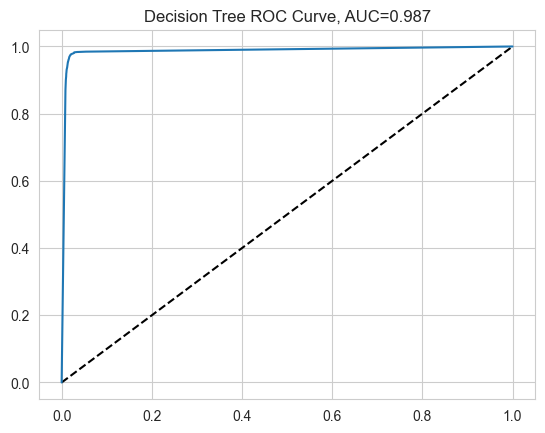

In [ ]:
# roc curves
from sklearn.metrics import roc_curve, roc_auc_score
y_pred_proba = best_tree.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.title(f'Decision Tree ROC Curve, AUC={ roc_auc_score(y_test, y_pred_proba):.3f}')
plt.show()

### K-nearest neighbors


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# grid search
accuracy_scores = []
f1_scores =[]
for i in tqdm(range(1, 10)):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

100%|██████████| 9/9 [01:52<00:00, 12.55s/it]


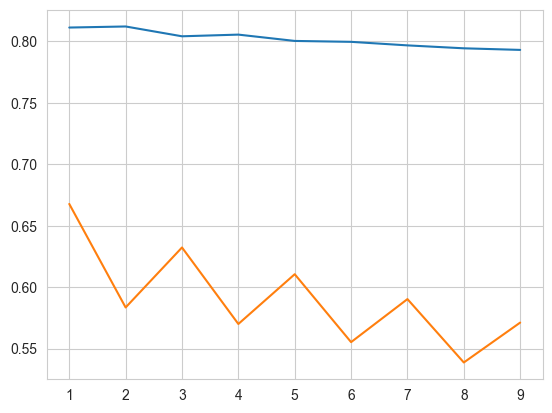

In [ ]:
plt.plot(range(1, 10), accuracy_scores)
plt.plot(range(1, 10), f1_scores)

### Discussion

We can see that the arguably simpler model of them all is almost perfect, with an accuracy of $97.8\%$ on the test set, and a F1-score of $0.97$.
Our hypothesis is that the task is almost linear due to the fact that we have the features `n_injured` and `n_unharmed`. While those two features are not directly correlated to the label, it's easy to understand that $ n_{killed} \approx n_{participants}- n_{injured}- n_{unharmed} -n_{arrested}$        in the majority of cases.

We can verify our hypothesis by looking at the weights of the model:

In [ ]:
for feature, weight in zip(X.columns, logreg.coef_[0]):
    print(feature, weight)

We see that the order of magnitude of the weights is between $O(1)$ and $O(10)$, for the aforementioned features, while is smaller ($O(10^{-1})$ to $O(10^{-3})$) for almost all the other. This means that the leading computation is $n_{participants}- n_{injured} - n_{unharmed} - n_{arrested}$.

For this reason, we decided to not use the features `n_injured`, `n_unharmed` and `n_arrested` in the following models.

## 3.2 Classification without 'n_injured', 'n_unharmed', and 'n_arrested'

We have seen that keeping those features leads to great results in classification, even with a simple model like logistic regression.
That is because `n_participants` $\approx$ `n_injured` + `n_unharmed` + `n_arrested`+ `n_killed`.
We decided to drop those features because, if the number of killed is unknown, it is reasonable that the number of injured, unharmed and arrested could also be unknown.

In [ ]:
X2=X.drop(['n_injured', 'n_unharmed', 'n_arrested'], axis=1)

In [ ]:
X2.head()

,latitude,longitude,year,povertyPercentage,population,candidatevotes,right_or_left,voters_over_population,n_participants,n_participants_teen,...,age_group_[12-17],age_group_[18-24],age_group_[25-34],age_group_[35-44],age_group_[45-54],age_group_[55-64],age_group_[65-74],age_group_[75-100],party_DEMOCRAT,party_REPUBLICAN
0,39.8322,-86.2492,2015.0,12.3,6608422,61443.0,0.452677,0.203046,1.0,0.0,...,0,1,0,0,0,0,0,0,1,0
1,39.7745,-86.1166,2015.0,12.3,6608422,61443.0,0.452677,0.203046,2.0,0.0,...,0,0,1,0,0,0,0,0,1,0
2,39.7759,-86.2940,2015.0,12.3,6608422,61443.0,0.452677,0.203046,2.0,0.0,...,0,0,0,1,0,0,0,0,1,0
3,39.8040,-86.0095,2015.0,12.3,6608422,61443.0,0.452677,0.203046,1.0,0.0,...,0,1,0,0,0,0,0,0,1,0
4,39.7882,-86.2091,2015.0,12.3,6608422,61443.0,0.452677,0.203046,1.0,0.0,...,0,0,0,0,1,0,0,0,1,0


In [ ]:
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, stratify=y, test_size=0.2, random_state=42)

### 3.2.1 Logistic regression

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
scaler = StandardScaler()
X2_train_scaled = scaler.fit_transform(X2_train)
X2_test_scaled = scaler.fit_transform(X2_test)
logreg2 = LogisticRegression()
logreg2.fit(X2_train_scaled, y_train)
results_logreg2 = evaluate_model(logreg2, X2_train_scaled, y_train, X2_test_scaled, y_test)

Accuracy on training set:  0.718717115444135
confusion_matrix on training set: 
 [[91286  1619]
 [34734  1601]]
Accuracy on validation set:  0.7188177034973693
Confusion matrix: 
 [[22832   394]
 [ 8691   393]]
Classification report: 
               precision    recall  f1-score   support

       False       0.72      0.98      0.83     23226
        True       0.50      0.04      0.08      9084

    accuracy                           0.72     32310
   macro avg       0.61      0.51      0.46     32310
weighted avg       0.66      0.72      0.62     32310



In [ ]:
# weights of model
for i in zip(X2.columns, logreg2.coef_[0]):
    print(i)

('latitude', -0.22790612591528284)
('longitude', -0.15650449889271636)
('year', 0.010174639566656088)
('povertyPercentage', -0.0022597002095804605)
('population', -0.04695287032605304)
('candidatevotes', 0.010518710146574092)
('right_or_left', -0.12164973902830145)
('voters_over_population', -0.15400009927258226)
('n_participants', -0.13222351307693564)
('n_participants_teen', 0.04145714129663868)
('n_participants_child', 0.05030380425126637)
('n_females', 0.18559036699301323)
('n_males', 0.31285555852398184)
('age_group_[0-11]', -0.09322618633001656)
('age_group_[12-17]', -0.17940536712786967)
('age_group_[18-24]', -0.08105962443788459)
('age_group_[25-34]', 0.02980879520335465)
('age_group_[35-44]', 0.07995762496436773)
('age_group_[45-54]', 0.10338442585716469)
('age_group_[55-64]', 0.08417443253575532)
('age_group_[65-74]', 0.046534368252859094)
('age_group_[75-100]', 0.03828946570494916)
('party_DEMOCRAT', 0.004510225288789716)
('party_REPUBLICAN', -0.004510225288789716)


In [ ]:
# correlation n_killed and n_injured
df_orig['isKilled'] = df_incidents_prepared['isKilled']
df_orig['isInjured'] = df_orig['n_injured'] > 0
df_orig['isKilled'].corr(df_orig['isInjured'])

-0.3597385293540303

### 3.2.2 Decision Trees

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

#### Grid search for Decision Tree Parameters

In [ ]:
param_grid = {'max_depth': [10, 20, 30],
              'min_samples_split': [2,3,4],
              'criterion': ['gini']
}

best_params_dt2 = grid_search_kfold_cv(model_class=DecisionTreeClassifier, param_grid=param_grid, X_train=X2_train, y_train=y_train, X_test=X2_test, y_test=y_test,  cv=3, metric='f1', eval=False)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END criterion=gini, max_depth=10, min_samples_split=2;, score=0.230 total time=   0.7s
[CV 2/3] END criterion=gini, max_depth=10, min_samples_split=2;, score=0.174 total time=   0.7s
[CV 3/3] END criterion=gini, max_depth=10, min_samples_split=2;, score=0.211 total time=   1.8s
[CV 1/3] END criterion=gini, max_depth=10, min_samples_split=3;, score=0.230 total time=   0.7s
[CV 2/3] END criterion=gini, max_depth=10, min_samples_split=3;, score=0.174 total time=   0.7s
[CV 3/3] END criterion=gini, max_depth=10, min_samples_split=3;, score=0.211 total time=   0.7s
[CV 1/3] END criterion=gini, max_depth=10, min_samples_split=4;, score=0.231 total time=   0.8s
[CV 2/3] END criterion=gini, max_depth=10, min_samples_split=4;, score=0.174 total time=   1.5s
[CV 3/3] END criterion=gini, max_depth=10, min_samples_split=4;, score=0.211 total time=   0.6s
[CV 1/3] END criterion=gini, max_depth=20, min_samples_split=2;, score=0.323

In [ ]:
best_params_dt2

{'criterion': 'gini', 'max_depth': 30, 'min_samples_split': 2}

In [ ]:
best_tree2 =DecisionTreeClassifier(**best_params_dt2)
best_tree2.fit(X2_train, y_train)
results_dt2 = evaluate_model(best_tree2,X2_train, y_train, X2_test, y_test)

Accuracy on training set:  0.9624110182606004
confusion_matrix on training set: 
 [[92227   678]
 [ 4180 32155]]
Accuracy on validation set:  0.6571030640668524
Confusion matrix: 
 [[17978  5248]
 [ 5831  3253]]
Classification report: 
               precision    recall  f1-score   support

       False       0.76      0.77      0.76     23226
        True       0.38      0.36      0.37      9084

    accuracy                           0.66     32310
   macro avg       0.57      0.57      0.57     32310
weighted avg       0.65      0.66      0.65     32310



We can see that the best model in grid search is overfitting the training set and doing poorly in validation. Simpler models and regularization don't help, because the best model outputted by the grid search is the one with the biggest depth and the minimum number of samples for splitting.
 The accuracy of $65\%$ in test is lower than the accuracy of the trivial classifier that outputs always False.

 Our  guess is that the reason is that the available features are not enough to generalize the classification results. We can also see from the ROC curve that the model is not able to achieve any tradeoff between TPR and TNR.


#### Try balancing data

A reason for the poor performance could be the inbalance between the two labels. To see if that's the case, we trained the model with _undersampling_ and _oversampling_ training set.
The undersampled training set has over 30.000 examples for each label, the oversampled one has over 90.000 examples per label.

##### Undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=41)
X2_undersampled, y_undersampled = rus.fit_resample(X2_train, y_train)
y_undersampled.value_counts()

False    36335
True     36335
Name: isKilled, dtype: int64

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
f1 = make_scorer(f1_score, pos_label =True)
param_grid = {'max_depth': [4, 8, 16],
              'min_samples_split': [2,4, 8, 16],
              'criterion': ['gini', 'entropy']
}
grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=3, scoring='f1', verbose =3)
grid.fit(X2_undersampled, y_undersampled)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=2;, score=0.648 total time=   0.2s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=2;, score=0.633 total time=   0.2s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=2;, score=0.641 total time=   0.2s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=4;, score=0.648 total time=   0.2s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=4;, score=0.633 total time=   0.2s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=4;, score=0.641 total time=   0.3s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.648 total time=   0.2s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.633 total time=   0.2s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.641 total time=   0.2s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=16;, score=0.648 total t

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 8, 16],
                         'min_samples_split': [2, 4, 8, 16]},
             scoring='f1', verbose=3)

In [ ]:
grid.best_params_

{'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 2}

In [ ]:
# new grid
param_grid = {'max_depth': [4,5,6,7,8],
              'min_samples_split': [6,7,8,9,10],
              'criterion': ['gini']
}
best_param_dt_under, best_tree_under, result_dt_under = grid_search_kfold_cv(model_class=DecisionTreeClassifier, param_grid=param_grid, X_train=X2_undersampled, y_train=y_undersampled, X_test=X2_test, y_test=y_test,  cv=3, metric='f1', eval=True)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=6;, score=0.648 total time=   0.2s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=6;, score=0.633 total time=   0.2s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=6;, score=0.641 total time=   0.2s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=7;, score=0.648 total time=   0.2s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=7;, score=0.633 total time=   0.2s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=7;, score=0.641 total time=   0.2s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.648 total time=   0.2s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.633 total time=   0.2s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.641 total time=   0.2s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=9;, score=0.648 total ti

##### Oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X2_oversampled, y_oversampled = ros.fit_resample(X2_train, y_train)
y_oversampled.value_counts()

False    92905
True     92905
Name: isKilled, dtype: int64

In [ ]:

param_grid = {'max_depth': [4, 8, 16],
              'min_samples_split': [2,4, 8, 16],
              'criterion': ['gini', 'entropy']
}
best_param_dt_over, best_tree_over, result_dt_over = grid_search_kfold_cv(model_class=DecisionTreeClassifier, param_grid=param_grid, X_train=X2_oversampled, y_train=y_oversampled, X_test=X2_test, y_test=y_test,  cv=3, metric='f1', eval=True)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=2;, score=0.651 total time=   0.8s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=2;, score=0.650 total time=   0.7s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=2;, score=0.654 total time=   0.6s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=4;, score=0.651 total time=   0.6s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=4;, score=0.650 total time=   0.6s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=4;, score=0.654 total time=   0.6s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.651 total time=   0.6s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.650 total time=   0.6s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.654 total time=   0.6s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=16;, score=0.651 total t

In [ ]:
grid.best_params_

{'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 2}

In [ ]:
tree_oversampled = DecisionTreeClassifier(random_state=42, max_depth=16, min_samples_split=6,  criterion='gini')
tree_oversampled.fit(X2_oversampled, y_oversampled)

DecisionTreeClassifier(max_depth=16, min_samples_split=6, random_state=42)

In [ ]:
y_pred = tree_oversampled.predict(X2_test)
y_pred_train = tree_oversampled.predict(X2_oversampled)
print('Accuracy on training set: ', accuracy_score(y_oversampled, y_pred_train))
print('confusion_matrix on training set: \n', confusion_matrix(y_oversampled, y_pred_train))
print('Accuracy on validation set: ', accuracy_score(y_test, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification report: \n', classification_report(y_test, y_pred))

Accuracy on training set:  0.7467628222377698
confusion_matrix on training set: 
 [[65364 27541]
 [19513 73392]]
Accuracy on validation set:  0.623800680903745
Confusion matrix: 
 [[14809  8417]
 [ 3738  5346]]
Classification report: 
               precision    recall  f1-score   support

       False       0.80      0.64      0.71     23226
        True       0.39      0.59      0.47      9084

    accuracy                           0.62     32310
   macro avg       0.59      0.61      0.59     32310
weighted avg       0.68      0.62      0.64     32310



##### SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X2_smote, y_smote = smote.fit_resample(X2_train, y_train)
y_smote.value_counts()

False    92905
True     92905
Name: isKilled, dtype: int64

In [ ]:
param_grid = {'max_depth': [4, 8, 16],
              'min_samples_split': [2,4, 8, 16],
              'criterion': ['gini', 'entropy']
}
best_param_dt_smote, best_tree_smote, result_dt_smote = grid_search_kfold_cv(model_class=DecisionTreeClassifier, param_grid=param_grid, X_train=X2_smote, y_train=y_smote, X_test=X2_test, y_test=y_test,  cv=3, metric='f1', eval=True)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=2;, score=0.577 total time=   0.7s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=2;, score=0.640 total time=   0.6s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=2;, score=0.627 total time=   0.6s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=4;, score=0.577 total time=   0.6s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=4;, score=0.640 total time=   0.6s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=4;, score=0.627 total time=   0.6s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.577 total time=   0.7s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.640 total time=   0.7s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.627 total time=   0.7s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=16;, score=0.577 total t

### 3.2.3 KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
# train model
accuracy_scores = []
f1_scores =[]
for i in tqdm(range(1, 10)):
    knn2 = KNeighborsClassifier(n_neighbors=i)
    knn2.fit(X2_train, y_train)
    y_pred = knn2.predict(X2_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

100%|██████████| 9/9 [01:20<00:00,  8.94s/it]


Text(0.5, 1.0, 'accuracy and f1-score for different k values')

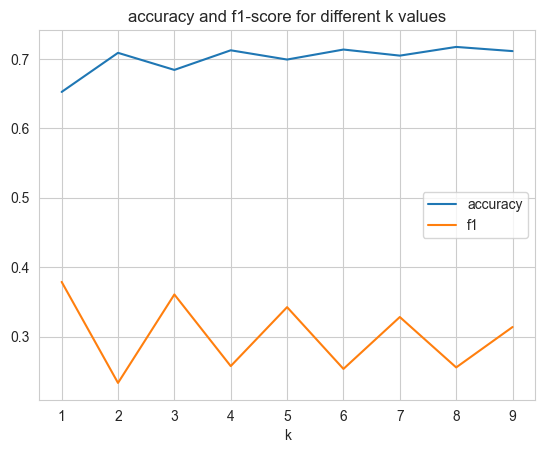

In [ ]:
plt.plot(range(1, 10), accuracy_scores)
plt.plot(range(1, 10), f1_scores)
plt.xlabel('k')
plt.legend(['accuracy' ,'f1'])
plt.title('accuracy and f1-score for different k values')



In [ ]:
# train again with best k
knn2 = KNeighborsClassifier(n_neighbors=5)
knn2.fit(X2_train, y_train)
results_knn2 = evaluate_model(knn2, X2_train, y_train, X2_test, y_test)

Accuracy on training set:  0.7772670999690499
confusion_matrix on training set: 
 [[85102  7803]
 [20983 15352]]
Accuracy on validation set:  0.6988238935314144
Confusion matrix: 
 [[20046  3180]
 [ 6551  2533]]
Classification report: 
               precision    recall  f1-score   support

       False       0.75      0.86      0.80     23226
        True       0.44      0.28      0.34      9084

    accuracy                           0.70     32310
   macro avg       0.60      0.57      0.57     32310
weighted avg       0.67      0.70      0.67     32310



### 3.2.4 Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier


In [ ]:
# grid search for random forest
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [16, 32],
              'min_samples_split': [ 2, 4, 8],
              'criterion': ['gini', 'entropy'],
              'n_estimators': [ 10, 20, 30]
}

best_params_rf2 = grid_search_kfold_cv(model_class=RandomForestClassifier, param_grid=param_grid,
                                       X_train=X2_train, y_train=y_train, X_test=X2_test, y_test=y_test,  cv=3,metric='f1', eval=False, verbose=3)

In [ ]:
best_params_rf2

{'criterion': 'gini',
 'max_depth': 32,
 'min_samples_split': 2,
 'n_estimators': 30}

In [ ]:
# train model with best parameters
rf2 = RandomForestClassifier(**best_params_rf2)
rf2.fit(X2_train, y_train)
results_rf2 = evaluate_model(rf2, X2_train, y_train, X2_test, y_test)


Accuracy on training set:  0.9901810584958217
confusion_matrix on training set: 
 [[92797   108]
 [ 1161 35174]]
Accuracy on validation set:  0.7
Confusion matrix: 
 [[19833  3393]
 [ 6300  2784]]
Classification report: 
               precision    recall  f1-score   support

       False       0.76      0.85      0.80     23226
        True       0.45      0.31      0.36      9084

    accuracy                           0.70     32310
   macro avg       0.60      0.58      0.58     32310
weighted avg       0.67      0.70      0.68     32310



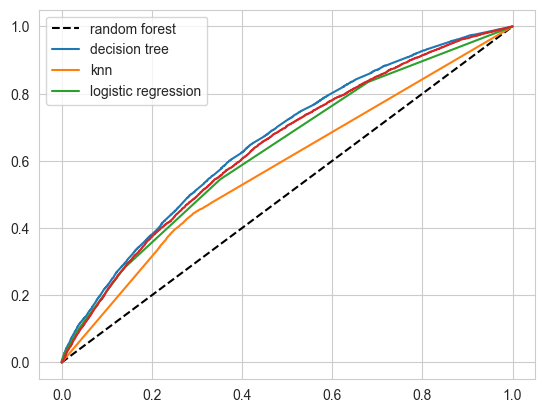

In [ ]:
# roc curves af all the models

y_pred_proba_rf = rf2.predict_proba(X2_test)[:,1]
y_pred_proba_dt = best_tree2.predict_proba(X2_test)[:,1]
y_pred_proba_knn = knn2.predict_proba(X2_test)[:,1]
y_pred_proba_logreg = logreg2.predict_proba(X2_test_scaled)[:,1]

plt.plot([0,1], [0,1], 'k--')

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_proba_rf)
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_proba_dt)
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_pred_proba_knn)
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_test, y_pred_proba_logreg)

plt.plot(fpr_rf, tpr_rf)
plt.plot(fpr_dt, tpr_dt)
plt.plot(fpr_knn, tpr_knn)
plt.plot(fpr_logreg, tpr_logreg)
plt.legend([ f'random forest', 'decision tree', 'knn', 'logistic regression'])



### 3.2.5 Discussion

In this case, none of the model we tried was able to achieve good performances on the test set. It is evident that having only the features `n_participants`, `n_participants_adult`, `n_participants_child`, `n_participants_teen`, `n_participants_females` is not enough to predict the number of killed in a shooting. We can then try to add at least the feature `n_injured` to see if the performances improve.

## 3.3 Classification using n_injured and n_participants

In [ ]:
X3=df_incidents_prepared.drop('isKilled', axis=1)

In [ ]:
X3.drop(['n_unharmed', 'n_arrested'], axis=1, inplace=True)

In [ ]:
X3.head()

,latitude,longitude,year,age_group,povertyPercentage,population,party,candidatevotes,right_or_left,voters_over_population,n_participants,n_participants_teen,n_participants_child,n_females,n_males,n_injured
0,39.8322,-86.2492,2015.0,[18-24],12.3,6608422,DEMOCRAT,61443.0,0.452677,0.203046,1.0,0.0,0.0,0.0,1.0,1
1,39.7745,-86.1166,2015.0,[25-34],12.3,6608422,DEMOCRAT,61443.0,0.452677,0.203046,2.0,0.0,0.0,0.0,2.0,0
2,39.7759,-86.2940,2015.0,[35-44],12.3,6608422,DEMOCRAT,61443.0,0.452677,0.203046,2.0,0.0,0.0,0.0,2.0,0
3,39.8040,-86.0095,2015.0,[18-24],12.3,6608422,DEMOCRAT,61443.0,0.452677,0.203046,1.0,0.0,0.0,0.0,1.0,0
4,39.7882,-86.2091,2015.0,[45-54],12.3,6608422,DEMOCRAT,61443.0,0.452677,0.203046,1.0,0.0,0.0,0.0,1.0,1


In [ ]:
# one hot encoding
X3=pd.get_dummies(X3)

In [ ]:
X3_train, X3_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)

### Decision Tree

In [ ]:
# grid search
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth': [4, 8, 16],
              'min_samples_split': [2,4, 8, 16],
              'criterion': ['gini', 'entropy']
}

best_params_dt3, best_tree3, result_dt3 = grid_search_kfold_cv(model_class=DecisionTreeClassifier, param_grid=param_grid, X_train=X3_train, y_train=y_train, X_test=X3_test, y_test=y_test,  cv=3, metric='f1', eval=True)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=2;, score=0.537 total time=   0.3s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=2;, score=0.571 total time=   0.3s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=2;, score=0.560 total time=   0.3s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=4;, score=0.537 total time=   0.3s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=4;, score=0.571 total time=   0.3s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=4;, score=0.560 total time=   0.3s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.537 total time=   0.3s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.571 total time=   0.2s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.560 total time=   0.3s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=16;, score=0.537 total t

### Random Forest

In [ ]:
# grid search

param_grid_rf = {'max_depth': [4, 8, 16],
              'min_samples_split': [ 2, 4, 8],
              'criterion': ['gini', 'entropy'],
              'n_estimators': [ 20, 30, 50]
}

best_params_rf3, best_rf3, result_rf3 = grid_search_kfold_cv(model_class=RandomForestClassifier,
                                                            param_grid=param_grid_rf, X_train=X3_train, y_train=y_train, X_test=X3_test, y_test=y_test,  cv=3,
                                                            metric='f1', eval=True)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=2, n_estimators=20;, score=0.023 total time=   0.9s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=2, n_estimators=20;, score=0.020 total time=   0.9s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=2, n_estimators=20;, score=0.035 total time=   0.9s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=2, n_estimators=30;, score=0.037 total time=   1.3s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=2, n_estimators=30;, score=0.037 total time=   1.4s
[CV 3/3] END criterion=gini, max_depth=4, min_samples_split=2, n_estimators=30;, score=0.040 total time=   1.3s
[CV 1/3] END criterion=gini, max_depth=4, min_samples_split=2, n_estimators=50;, score=0.053 total time=   2.2s
[CV 2/3] END criterion=gini, max_depth=4, min_samples_split=2, n_estimators=50;, score=0.038 total time=   2.3s
[CV 3/3] END criterion=gini, max_depth=4, 

<Axes: >

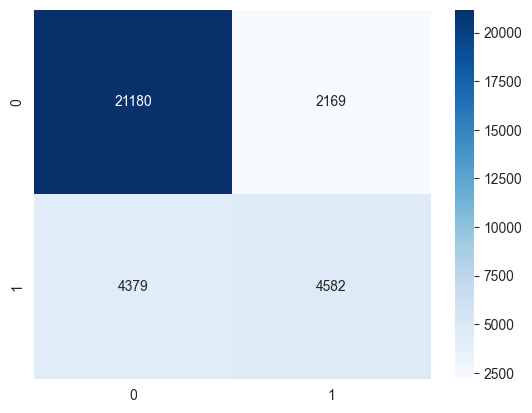

In [ ]:
# plot confusion matrix
y_pred = best_rf3.predict(X3_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')


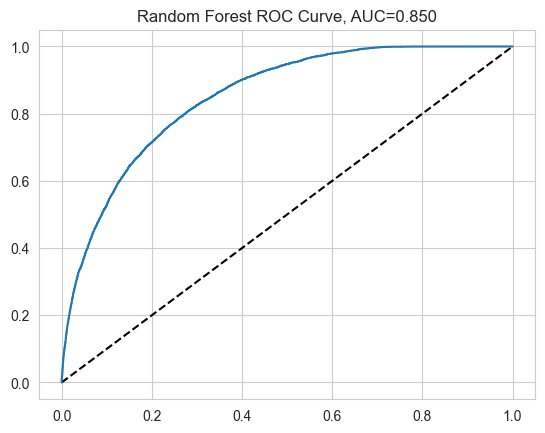

In [ ]:
# roc curve
from sklearn.metrics import roc_curve, roc_auc_score
y_pred_proba = best_rf3.predict_proba(X3_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.title(f'Random Forest ROC Curve, AUC={ roc_auc_score(y_test, y_pred_proba):.3f}')
plt.show()

### ADABoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
sampler=RandomUnderSampler()
X3_tr_us, y3_train_us= sampler.fit_resample(X3_train, y_train)

In [ ]:
ada_boost = AdaBoostClassifier(n_estimators=100, learning_rate=1, base_estimator=LogisticRegression())

In [ ]:
ada_boost.fit(X3_tr_us, y3_train_us)

AdaBoostClassifier(base_estimator=LogisticRegression(), learning_rate=1,
                   n_estimators=100)

In [ ]:
result_ab3=evaluate_model(model=ada_boost, X_train=X3_train, y_train=y_train, X_test=X3_test, y_test=y_test)

Accuracy on training set:  0.3465103683070257
confusion_matrix on training set: 
 [[13834 79071]
 [ 5386 30949]]
Accuracy on validation set:  0.34589910244506344
Confusion matrix: 
 [[ 3508 19718]
 [ 1416  7668]]
Classification report: 
               precision    recall  f1-score   support

       False       0.71      0.15      0.25     23226
        True       0.28      0.84      0.42      9084

    accuracy                           0.35     32310
   macro avg       0.50      0.50      0.33     32310
weighted avg       0.59      0.35      0.30     32310



### Neural Networks

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers

scaler = StandardScaler()
X=df_incidents_prepared.drop('isKilled', axis=1)
X.drop(['n_unharmed', 'n_arrested'], axis=1, inplace=True)
X=pd.get_dummies(X)
X.shape

(161550, 25)

In [ ]:

X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.2, random_state=42, stratify=y_train)

X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)
X_val_scaled=scaler.transform(X_val)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161550 entries, 0 to 164506
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   latitude                161550 non-null  float64
 1   longitude               161550 non-null  float64
 2   year                    161550 non-null  float64
 3   povertyPercentage       161550 non-null  float64
 4   population              161550 non-null  int64  
 5   candidatevotes          161550 non-null  float64
 6   right_or_left           161550 non-null  float64
 7   voters_over_population  161550 non-null  float64
 8   n_participants          161550 non-null  float64
 9   n_participants_teen     161550 non-null  float64
 10  n_participants_child    161550 non-null  float64
 11  n_females               161550 non-null  float64
 12  n_males                 161550 non-null  float64
 13  n_injured               161550 non-null  int64  
 14  age_group_[0-11]    

In [ ]:
input_size = X_train.shape[1]

In [ ]:
model = Sequential([Dense(32, activation='relu', input_shape=(input_size, ) ),
                    Dense(16, activation='relu'),
                    Dense(1, activation='sigmoid')])

In [ ]:
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

sampler = RandomUnderSampler(random_state=42)
X_train_scaled, y_train = sampler.fit_resample(X_train_scaled, y_train)

In [ ]:
early_stopping= EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=10, callbacks=[early_stopping])

Epoch 1/10
1823/1823 [==============================] - 6s 3ms/step - loss: 0.5483 - accuracy: 0.7102 - val_loss: 0.5305 - val_accuracy: 0.6996
Epoch 2/10
1823/1823 [==============================] - 5s 3ms/step - loss: 0.5050 - accuracy: 0.7370 - val_loss: 0.5006 - val_accuracy: 0.7191
Epoch 3/10
1823/1823 [==============================] - 5s 3ms/step - loss: 0.4977 - accuracy: 0.7416 - val_loss: 0.4843 - val_accuracy: 0.7298
Epoch 4/10
1823/1823 [==============================] - 5s 3ms/step - loss: 0.4934 - accuracy: 0.7435 - val_loss: 0.4986 - val_accuracy: 0.7163
Epoch 5/10
1823/1823 [==============================] - 5s 3ms/step - loss: 0.4901 - accuracy: 0.7456 - val_loss: 0.4936 - val_accuracy: 0.7242
Epoch 6/10
1823/1823 [==============================] - 5s 3ms/step - loss: 0.4879 - accuracy: 0.7484 - val_loss: 0.4961 - val_accuracy: 0.7206
Epoch 7/10
1823/1823 [==============================] - 5s 3ms/step - loss: 0.4865 - accuracy: 0.7488 - val_loss: 0.5096 - val_accuracy:

In [ ]:
y_pred = model.predict(X_test_scaled)
y_pred_train = model.predict(X_train_scaled)
y_pred = y_pred > 0.5
y_pred_train = y_pred_train > 0.5
print('Accuracy on training set: ', accuracy_score(y_train, y_pred_train))
print('confusion_matrix on training set: \n', confusion_matrix(y_train, y_pred_train))
print('Accuracy on test set: ', accuracy_score(y_test, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification report: \n', classification_report(y_test, y_pred))

1823/1823 [==============================] - 3s 2ms/step
Accuracy on training set:  0.7438455736131112
confusion_matrix on training set: 
 [[21248  7918]
 [ 7024 22142]]
Accuracy on test set:  0.7337975858867224
Confusion matrix: 
 [[16913  6436]
 [ 2165  6796]]
Classification report: 
               precision    recall  f1-score   support

       False       0.89      0.72      0.80     23349
        True       0.51      0.76      0.61      8961

    accuracy                           0.73     32310
   macro avg       0.70      0.74      0.70     32310
weighted avg       0.78      0.73      0.75     32310



In [ ]:
param_grid={
    'optimizer': ['adam'],
    'first_layer_size': [ 32, 64],
    'second_layer_size': [16, 32],
    'reg_strength': [0.0001, 0.001, 0.01,],
    'lr':[0.001, 0.0001]
}

In [ ]:

from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras
def kfold(X, y, k):
    for i in range(k+1):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=int(X.shape[0]/k), random_state=i)
        yield X_train, X_test, y_train, y_test

def grid_search_kfold(X,y, k, param_grid):
    best_score =0
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    for params in tqdm(ParameterGrid(param_grid)):
        #train on the k-1 folds

        model =Sequential([
                          Dense(params['first_layer_size'], activation='relu',
                                input_shape=(X.shape[1],), kernel_regularizer=l2(params['reg_strength'])),
                          Dense(params['second_layer_size'], activation='relu', kernel_regularizer=l2(params['reg_strength'])),
                          Dense(1, activation='sigmoid', kernel_regularizer=l2(params['reg_strength']))
                          ]
                        )
        early_stopping= EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')
        if params['optimizer']=='adam':
          opt= keras.optimizers.Adam(learning_rate=params['lr'])
        else:
          opt= keras.optimizers.SGD(learning_rate=params['lr'])
          
        model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, callbacks=[early_stopping], verbose=True)
        score = model.evaluate(X_test, y_test)
        print(score)
        if score[1] > best_score:
            best_score = score[1]
            best_params = params
    return best_params, best_score


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X3_train_scaled=scaler.fit_transform(X3_train)

In [ ]:
best_params, best_score = grid_search_kfold(X3_train_scaled, y_train, 3, param_grid)

In [38]:
print(best_params, best_score)

{'first_layer_size': 32, 'lr': 0.001, 'optimizer': 'adam', 'reg_strength': 0.0001, 'second_layer_size': 32} 0.7825750708580017


In [41]:
best_nn = Sequential([
                            Dense(32, activation='relu',
                                    input_shape=(X3_train_scaled.shape[1],), kernel_regularizer=l2(0.0001)),
                            Dense(32, activation='relu', kernel_regularizer=l2(0.0001)),
                            Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001))
                            ]
                            )
best_nn.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
X3_test_scaled=scaler.transform(X3_test)
early_stopping= EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')
best_nn.fit(X3_train_scaled, y_train, validation_data=(X3_test_scaled, y_test), epochs=100, callbacks=[early_stopping], verbose=True)


Epoch 1/100
4039/4039 [==============================] - 15s 4ms/step - loss: 0.4719 - accuracy: 0.7581 - val_loss: 0.4487 - val_accuracy: 0.7717
Epoch 2/100
4039/4039 [==============================] - 14s 3ms/step - loss: 0.4475 - accuracy: 0.7735 - val_loss: 0.4414 - val_accuracy: 0.7766
Epoch 3/100
4039/4039 [==============================] - 14s 3ms/step - loss: 0.4424 - accuracy: 0.7760 - val_loss: 0.4411 - val_accuracy: 0.7799
Epoch 4/100
4039/4039 [==============================] - 14s 4ms/step - loss: 0.4401 - accuracy: 0.7788 - val_loss: 0.4370 - val_accuracy: 0.7834
Epoch 5/100
4039/4039 [==============================] - 14s 4ms/step - loss: 0.4384 - accuracy: 0.7789 - val_loss: 0.4390 - val_accuracy: 0.7799
Epoch 6/100
4039/4039 [==============================] - 14s 4ms/step - loss: 0.4373 - accuracy: 0.7808 - val_loss: 0.4334 - val_accuracy: 0.7835
Epoch 7/100
4039/4039 [==============================] - 14s 3ms/step - loss: 0.4363 - accuracy: 0.7812 - val_loss: 0.4344 -

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
y_pred = best_nn.predict(X3_test_scaled)
y_pred_train = best_nn.predict(X3_train_scaled)
y_pred = y_pred > 0.5
y_pred_train = y_pred_train > 0.5
print('Accuracy on training set: ', accuracy_score(y_train, y_pred_train))
print('confusion_matrix on training set: \n', confusion_matrix(y_train, y_pred_train))
print('Accuracy on test set: ', accuracy_score(y_test, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification report: \n', classification_report(y_test, y_pred))


   1/1010 [..............................] - ETA: 40s

4039/4039 [==============================] - 9s 2ms/step
Accuracy on training set:  0.7860105230578768
confusion_matrix on training set: 
 [[83017  9765]
 [17891 18567]]
Accuracy on test set:  0.7866914268028474
Confusion matrix: 
 [[20900  2449]
 [ 4443  4518]]
Classification report: 
               precision    recall  f1-score   support

       False       0.82      0.90      0.86     23349
        True       0.65      0.50      0.57      8961

    accuracy                           0.79     32310
   macro avg       0.74      0.70      0.71     32310
weighted avg       0.78      0.79      0.78     32310



In [ ]:
y_pred = best_nn.predict(X3_test_scaled)


In [69]:
def plot_roc_curve(y_pred, y_test):
    y_pred=y_pred.reshape((y_pred.shape[0],))
    thresholds = np.linspace(0, 1, 100)
    tpr = []
    fpr = []
    for threshold in thresholds:
        y_pred_threshold = y_pred > threshold
     
        true_positive = np.sum(y_pred_threshold * y_test)
        false_positive = np.sum(y_pred_threshold * (1-y_test))
        true_negative = np.sum((1-y_pred_threshold) * (1-y_test))
        false_negative = np.sum((1-y_pred_threshold) * y_test)
        tpr.append(true_positive / (true_positive + false_negative))
        fpr.append(false_positive / (false_positive + true_negative))   
    return tpr, fpr, thresholds    




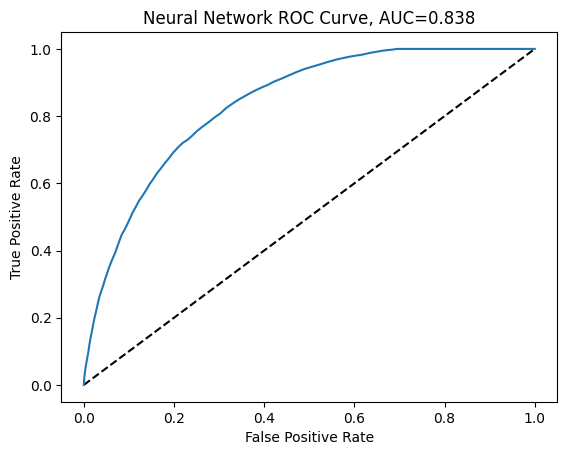

In [71]:
fpr, tpr, thresholds = plot_roc_curve(y_pred, y_test)
plt.plot([0,1], [0,1], 'k--')
plt.plot(tpr, fpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Neural Network ROC Curve, AUC={ roc_auc_score(y_test, y_pred):.3f}')
plt.show()


NameError: name 'best_rf3' is not defined

In [73]:
# save all the results
results = pd.DataFrame(columns=['confusion_matrix', 'classification_report'])
results.loc['logreg'] = results_logreg
results.loc['dt'] = results_dt
results.loc['dt2'] = results_dt2
results.loc['rf2'] = results_rf2
results.loc['knn2'] = results_knn2
results.loc['logreg2'] = results_logreg2
results.loc['dt3'] = result_dt3
results.loc['rf3'] = result_rf3
results.loc['nn3'] = {'confusion_matrix': confusion_matrix(y_test, y_pred), 'classification_report': classification_report(y_test, y_pred) }
results.to_csv('results.csv')

NameError: name 'results_logreg' is not defined

In [74]:
results= pd.read_csv('results.csv', index_col=False)

In [77]:
# add a new row
y_pred = y_pred>0.5
results.loc[-1] = {'model': 'nn3', 'confusion_matrix': confusion_matrix(y_test, y_pred), 'classification_report': classification_report(y_test, y_pred) }
